In [1]:
#import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
from scipy.stats import linregress
import matplotlib.cm as cm
import matplotlib.colors as mcol
import re

test=123b89e9b48123

api_key = "key here"

In [2]:
#Reading in csv and previewing data
movie_data_df = pd.read_csv("imdb (1000 movies) in june 2022.csv")
movie_data_df.head()

,ranking of movie\r\n,movie name\r\n,Year,certificate,runtime,genre,RATING,metascore,DETAIL ABOUT MOVIE\n,DIRECTOR\r\n,ACTOR 1\n,ACTOR 2\n,ACTOR 3,ACTOR 4,votes,GROSS COLLECTION\r\n
0,1,The Shawshank Redemption,-1994,15,142 min,Drama,9.3,81.0,Two imprisoned men bond over a number of years...,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,"2,603,314",$28.34M
1,2,The Godfather,-1972,X,175 min,"Crime, Drama",9.2,100.0,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,"1,798,731",$134.97M
2,3,The Dark Knight,-2008,12A,152 min,"Action, Crime, Drama",9.0,84.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,"2,574,810",$534.86M
3,4,The Lord of the Rings: The Return of the King,-2003,12A,201 min,"Action, Adventure, Drama",9.0,94.0,Gandalf and Aragorn lead the World of Men agai...,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,"1,787,701",$377.85M
4,5,Schindler's List,-1993,15,195 min,"Biography, Drama, History",9.0,94.0,"In German-occupied Poland during World War II,...",Steven Spielberg,Liam Neeson,Ralph Fiennes,Ben Kingsley,Caroline Goodall,"1,323,776",$96.90M


In [3]:
#renaming columns
clean_df = movie_data_df.rename(columns={
    "ranking of movie\r\n":"IMDB Rank",
    "movie name\r\n":"Movie Name",
    "certificate":"Rating",
    "runtime":"Runtime (Minutes)",
    "genre":"Genre",
    "RATING":"IMDB Score",
    "metascore":"Metascore",
    "DETAIL ABOUT MOVIE\n":"Details",
    "DIRECTOR\r\n":"Director",
    "ACTOR 1\n":"Actor 1",
    "ACTOR 2\n": "Actor 2",
    "ACTOR 3":"Actor 3",
    "ACTOR 4":"Actor 4",
    "votes":"IMDB Votes",
    "GROSS COLLECTION\r\n":"BoxOffice (Millions)"
})


#cleaning up columns and setting data types
#dropping null values
clean_df=clean_df.dropna()

# #cleaning year - removing "-" and setting to int

clean_df['Year'] = clean_df['Year'].str.extract(pat='(\d+)', expand=False)
clean_df["Year"]=clean_df["Year"].astype("int")

# #cleaning runtime and setting as int
clean_df["Runtime (Minutes)"]=clean_df["Runtime (Minutes)"].str.split(" ").str[0]
clean_df["Runtime (Minutes)"]=clean_df["Runtime (Minutes)"].astype("int")

# #clean up Genre to only get the first genre
clean_df["Main Genre"]=clean_df["Genre"].str.split(",").str[0]
clean_df["Sub Genre"]=clean_df["Genre"].str.split(",").str[1]
clean_df = clean_df.drop(columns="Genre")


#setting IMDB Score as int
clean_df["IMDB Score"]=clean_df["IMDB Score"].astype("float")

# #cleaning box office. Removing "$" and "M" and setting to float
clean_df["BoxOffice (Millions)"]=clean_df["BoxOffice (Millions)"].str.split("M").str[0]
clean_df["BoxOffice (Millions)"]=clean_df["BoxOffice (Millions)"].str.split("$").str[1]
clean_df["BoxOffice (Millions)"]=clean_df["BoxOffice (Millions)"].astype("float")

#Cleaning up IMDB votes and setting as int
clean_df["IMDB Votes"]=clean_df["IMDB Votes"].str.replace(",","")
clean_df["IMDB Votes"]=clean_df["IMDB Votes"].astype("int")


#standardize movie ratings
ratings = {"A":"G",
           "U":"G",
           "AA":"PG",
           "12":"PG",
           "15":"PG-13",
           "12A":"PG-13",
           "UA":"PG-13",
           "18":"R",
           "X":"NC17"}
clean_df["Rating"]=clean_df["Rating"].replace(ratings)

#resetting index and displaying
clean_df=clean_df.reset_index()
clean_df=clean_df.drop(columns="index")
clean_df.head()







,IMDB Rank,Movie Name,Year,Rating,Runtime (Minutes),IMDB Score,Metascore,Details,Director,Actor 1,Actor 2,Actor 3,Actor 4,IMDB Votes,BoxOffice (Millions),Main Genre,Sub Genre
0,1,The Shawshank Redemption,1994,PG-13,142,9.3,81.0,Two imprisoned men bond over a number of years...,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2603314,28.34,Drama,NaN
1,2,The Godfather,1972,NC17,175,9.2,100.0,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1798731,134.97,Crime,Drama
2,3,The Dark Knight,2008,PG-13,152,9.0,84.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2574810,534.86,Action,Crime
3,4,The Lord of the Rings: The Return of the King,2003,PG-13,201,9.0,94.0,Gandalf and Aragorn lead the World of Men agai...,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1787701,377.85,Action,Adventure
4,5,Schindler's List,1993,PG-13,195,9.0,94.0,"In German-occupied Poland during World War II,...",Steven Spielberg,Liam Neeson,Ralph Fiennes,Ben Kingsley,Caroline Goodall,1323776,96.90,Biography,Drama


In [4]:
#creating a new column to store award info
clean_df["Awards"]=""
clean_df.head()

,IMDB Rank,Movie Name,Year,Rating,Runtime (Minutes),IMDB Score,Metascore,Details,Director,Actor 1,Actor 2,Actor 3,Actor 4,IMDB Votes,BoxOffice (Millions),Main Genre,Sub Genre,Awards
0,1,The Shawshank Redemption,1994,PG-13,142,9.3,81.0,Two imprisoned men bond over a number of years...,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2603314,28.34,Drama,NaN,
1,2,The Godfather,1972,NC17,175,9.2,100.0,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1798731,134.97,Crime,Drama,
2,3,The Dark Knight,2008,PG-13,152,9.0,84.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2574810,534.86,Action,Crime,
3,4,The Lord of the Rings: The Return of the King,2003,PG-13,201,9.0,94.0,Gandalf and Aragorn lead the World of Men agai...,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1787701,377.85,Action,Adventure,
4,5,Schindler's List,1993,PG-13,195,9.0,94.0,"In German-occupied Poland during World War II,...",Steven Spielberg,Liam Neeson,Ralph Fiennes,Ben Kingsley,Caroline Goodall,1323776,96.90,Biography,Drama,


In [5]:
#search OMDB API for award info and put result in our new column

# for index, row in clean_df.iterrows():
#     try:
#         params = {
#         "apikey": api_key,
#         "t": row["Movie Name"]}
    
#         url = "http://www.omdbapi.com"
#         res = requests.get(url,params=params).json()
#         clean_df.loc[index,"Awards"]=res["Awards"]
#     except: 
#         pass
# clean_df.head()

In [6]:

# clean_df.to_csv("Refined_Data.csv",index=False)

In [11]:
test_df= pd.read_csv("Refined_Data.csv")
test_df.head()


,IMDB Rank,Movie Name,Year,Rating,Runtime (Minutes),IMDB Score,Metascore,Details,Director,Actor 1,Actor 2,Actor 3,Actor 4,IMDB Votes,BoxOffice (Millions),Main Genre,Sub Genre,Awards
0,1,The Shawshank Redemption,1994,PG-13,142,9.3,81.0,Two imprisoned men bond over a number of years...,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2603314,28.34,Drama,NaN,Nominated for 7 Oscars. 21 wins & 43 nominatio...
1,2,The Godfather,1972,NC17,175,9.2,100.0,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1798731,134.97,Crime,Drama,Won 3 Oscars. 32 wins & 31 nominations total
2,3,The Dark Knight,2008,PG-13,152,9.0,84.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2574810,534.86,Action,Crime,Won 2 Oscars. 162 wins & 163 nominations total
3,4,The Lord of the Rings: The Return of the King,2003,PG-13,201,9.0,94.0,Gandalf and Aragorn lead the World of Men agai...,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1787701,377.85,Action,Adventure,Won 11 Oscars. 213 wins & 124 nominations total
4,5,Schindler's List,1993,PG-13,195,9.0,94.0,"In German-occupied Poland during World War II,...",Steven Spielberg,Liam Neeson,Ralph Fiennes,Ben Kingsley,Caroline Goodall,1323776,96.90,Biography,Drama,Won 7 Oscars. 91 wins & 49 nominations total


In [16]:
test_df["Total Awards & Nominations"] = 0

In [17]:

for index, row in test_df.iterrows():
    try:
        tot_awards=re.findall(r'\d+', row["Awards"])
        test_df.loc[index,"Total Awards & Nominations"]= sum(map(int, tot_awards))
    except:
        pass
        
        
        
        





In [18]:
test_df.head()

,IMDB Rank,Movie Name,Year,Rating,Runtime (Minutes),IMDB Score,Metascore,Details,Director,Actor 1,Actor 2,Actor 3,Actor 4,IMDB Votes,BoxOffice (Millions),Main Genre,Sub Genre,Awards,Total Awards & Nominations
0,1,The Shawshank Redemption,1994,PG-13,142,9.3,81.0,Two imprisoned men bond over a number of years...,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2603314,28.34,Drama,NaN,Nominated for 7 Oscars. 21 wins & 43 nominatio...,71
1,2,The Godfather,1972,NC17,175,9.2,100.0,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1798731,134.97,Crime,Drama,Won 3 Oscars. 32 wins & 31 nominations total,66
2,3,The Dark Knight,2008,PG-13,152,9.0,84.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2574810,534.86,Action,Crime,Won 2 Oscars. 162 wins & 163 nominations total,327
3,4,The Lord of the Rings: The Return of the King,2003,PG-13,201,9.0,94.0,Gandalf and Aragorn lead the World of Men agai...,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1787701,377.85,Action,Adventure,Won 11 Oscars. 213 wins & 124 nominations total,348
4,5,Schindler's List,1993,PG-13,195,9.0,94.0,"In German-occupied Poland during World War II,...",Steven Spielberg,Liam Neeson,Ralph Fiennes,Ben Kingsley,Caroline Goodall,1323776,96.90,Biography,Drama,Won 7 Oscars. 91 wins & 49 nominations total,147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,989,The Jungle Book,1967,G,78,7.6,65.0,Bagheera the Panther and Baloo the Bear have a...,Wolfgang Reitherman,Phil Harris,Sebastian Cabot,Louis Prima,Bruce Reitherman,179851,141.84,Animation,Adventure,Won 1 Oscar. 33 wins & 55 nominations total,89
734,991,The Birds,1963,NC17,119,7.6,90.0,A wealthy San Francisco socialite pursues a po...,Alfred Hitchcock,Rod Taylor,Tippi Hedren,Jessica Tandy,Suzanne Pleshette,186123,11.40,Drama,Horror,Nominated for 1 Oscar. 5 wins & 7 nominations ...,13
735,994,Eyes Without a Face,1960,PG-13,90,7.6,90.0,A surgeon causes an accident which leaves his ...,Georges Franju,Pierre Brasseur,Alida Valli,Juliette Mayniel,Alexandre Rignault,31294,0.05,Drama,Horror,NaN,0
736,997,From Here to Eternity,1953,PG,118,7.6,85.0,"At a U.S. Army base in 1941 Hawaii, a private ...",Fred Zinnemann,Burt Lancaster,Montgomery Clift,Deborah Kerr,Donna Reed,46804,30.50,Drama,Romance,Won 8 Oscars. 25 wins & 9 nominations total,42


In [19]:
test_df.to_csv("Final_Data.csv",index=False)

# Does the amount of awards impact box office earnings?

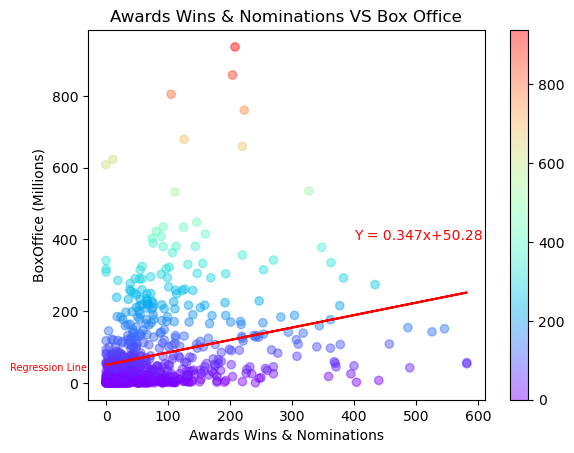

In [55]:
# Visualizations

#initializing x and y values
x=test_df["Total Awards & Nominations"]
y=test_df["BoxOffice (Millions)"]

#calculating regression line
def slopefunc(x):
    return (slope * x) + intercept
reg_line=slopefunc(x)

#plotting regression line
plt.plot(x,reg_line,color="red")

plt.scatter(x,y,alpha=.45,c=y,cmap="rainbow")
plt.title("Awards Wins & Nominations VS Box Office")
plt.ylabel("BoxOffice (Millions)")
plt.xlabel("Awards Wins & Nominations")
plt.text(400, 400, f'Y = {round(slope,3)}x+{round(intercept,3)}', fontsize = 10, color = "r")
plt.text(-155, 35, "Regression Line",fontsize = 7, color = "r")
plt.colorbar()
plt.show()


In [ ]:
#possibly do histogram